## **Import Libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D,Conv1DTranspose,Concatenate,Input
import numpy as np
import IPython.display
import glob
from tqdm.notebook import tqdm
import librosa.display
import matplotlib.pyplot as plt

## **Import & Prepare Data**

In [2]:
!wget https://datashare.ed.ac.uk/download/DS_10283_1942.zip

--2023-02-02 12:10:38--  https://datashare.ed.ac.uk/download/DS_10283_1942.zip
Resolving datashare.ed.ac.uk (datashare.ed.ac.uk)... 192.41.117.26
Connecting to datashare.ed.ac.uk (datashare.ed.ac.uk)|192.41.117.26|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: 2150533410 (2.0G) [application/zip]
Saving to: ‘DS_10283_1942.zip’

DS_10283_1942.zip   100%[===================>]   2.00G  1.01MB/s    in 31m 54s 

2023-02-02 12:42:33 (1.07 MB/s) - ‘DS_10283_1942.zip’ saved [2150533410/2150533410]



In [3]:
!unzip /content/DS_10283_1942.zip

Archive:  /content/DS_10283_1942.zip
  inflating: clean_trainset_wav.zip  
  inflating: noisy_trainset_wav.zip  
  inflating: noisy_testset_wav.zip   
  inflating: clean_testset_wav.zip   
  inflating: trainset_txt.zip        
  inflating: testset_txt.zip         
  inflating: license_text            


In [ ]:
!mkdir "CleanData"
!mkdir "NoisyData"

!unzip "/content/clean_trainset_wav.zip" -d "CleanData"
!unzip "/content/noisy_trainset_wav.zip" -d "NoisyData"

In [5]:
clean_sounds = glob.glob('/content/CleanData/*')
noisy_sounds = glob.glob('/content/NoisyData/*')

clean_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(clean_sounds[0]),desired_channels=1)
for i in tqdm(clean_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  clean_sounds_list = tf.concat((clean_sounds_list,so),0)

noisy_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(noisy_sounds[0]),desired_channels=1)
for i in tqdm(noisy_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  noisy_sounds_list = tf.concat((noisy_sounds_list,so),0)
clean_sounds_list.shape,noisy_sounds_list.shape

  0%|          | 0/11571 [00:00<?, ?it/s]

  0%|          | 0/11571 [00:00<?, ?it/s]

(TensorShape([540938091, 1]), TensorShape([540938091, 1]))

In [6]:
batching_size = 12000

clean_train,noisy_train = [],[]

for i in tqdm(range(0,clean_sounds_list.shape[0]-batching_size,batching_size)):
  clean_train.append(clean_sounds_list[i:i+batching_size])
  noisy_train.append(noisy_sounds_list[i:i+batching_size])

clean_train = tf.stack(clean_train)
noisy_train = tf.stack(noisy_train)

clean_train.shape,noisy_train.shape

  0%|          | 0/45078 [00:00<?, ?it/s]

(TensorShape([45078, 12000, 1]), TensorShape([45078, 12000, 1]))

In [7]:
def get_dataset(x_train,y_train):
  dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
  dataset = dataset.shuffle(100).batch(64,drop_remainder=True)
  return dataset

In [8]:
train_dataset = get_dataset(noisy_train[:40000],clean_train[:40000])
test_dataset = get_dataset(noisy_train[40000:],clean_train[40000:])

Clean Speech Visualization

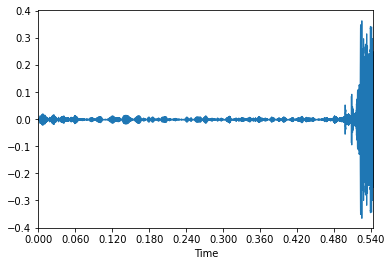

In [14]:
librosa.display.waveplot(np.squeeze(clean_train[23].numpy(),axis=-1))
plt.show()

Noisy Speech Visualization

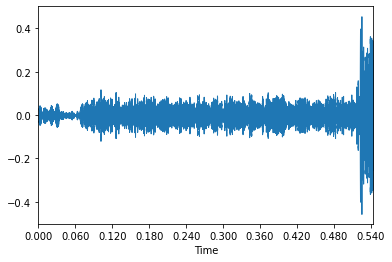

In [15]:
librosa.display.waveplot(np.squeeze(noisy_train[23].numpy(),axis=-1))
plt.show()

# **Model**

In [35]:
inp = Input(shape=(batching_size,1))
c1 = Conv1D(2,32,2,'same',activation='relu')(inp)
c2 = Conv1D(4,32,2,'same',activation='relu')(c1)
c3 = Conv1D(8,32,2,'same',activation='relu')(c2)
c4 = Conv1D(16,32,2,'same',activation='relu')(c3)
c5 = Conv1D(32,32,2,'same',activation='relu')(c4)

dc1 = Conv1DTranspose(32,32,1,padding='same')(c5)
conc = Concatenate()([c5,dc1])
dc2 = Conv1DTranspose(16,32,2,padding='same')(conc)
conc = Concatenate()([c4,dc2])
dc3 = Conv1DTranspose(8,32,2,padding='same')(conc)
conc = Concatenate()([c3,dc3])
dc4 = Conv1DTranspose(4,32,2,padding='same')(conc)
conc = Concatenate()([c2,dc4])
dc5 = Conv1DTranspose(2,32,2,padding='same')(conc)
conc = Concatenate()([c1,dc5])
dc6 = Conv1DTranspose(1,32,2,padding='same')(conc)
conc = Concatenate()([inp,dc6])
dc7 = Conv1DTranspose(1,32,1,padding='same',activation='linear')(conc)
model = tf.keras.models.Model(inp,dc7)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 12000, 1)]   0           []                               
                                                                                                  
 conv1d_51 (Conv1D)             (None, 6000, 2)      66          ['input_10[0][0]']               
                                                                                                  
 conv1d_52 (Conv1D)             (None, 3000, 4)      260         ['conv1d_51[0][0]']              
                                                                                                  
 conv1d_53 (Conv1D)             (None, 1500, 8)      1032        ['conv1d_52[0][0]']              
                                                                                            

### **Training**

In [36]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.MeanAbsoluteError())
history = model.fit(train_dataset,epochs=15)

Epoch 1/15
625/625 [==============================] - 23s 34ms/step - loss: 0.0192
Epoch 2/15
625/625 [==============================] - 22s 34ms/step - loss: 0.0147
Epoch 3/15
625/625 [==============================] - 21s 34ms/step - loss: 0.0137
Epoch 4/15
625/625 [==============================] - 21s 33ms/step - loss: 0.0134
Epoch 5/15
625/625 [==============================] - 21s 33ms/step - loss: 0.0129
Epoch 6/15
625/625 [==============================] - 21s 34ms/step - loss: 0.0127
Epoch 7/15
625/625 [==============================] - 21s 34ms/step - loss: 0.0125
Epoch 8/15
625/625 [==============================] - 21s 34ms/step - loss: 0.0124
Epoch 9/15
625/625 [==============================] - 22s 34ms/step - loss: 0.0123
Epoch 10/15
625/625 [==============================] - 21s 34ms/step - loss: 0.0123
Epoch 11/15
625/625 [==============================] - 21s 34ms/step - loss: 0.0122
Epoch 12/15
625/625 [==============================] - 22s 35ms/step - loss: 0.0121
E

In [37]:
from IPython.display import Audio
Audio(np.squeeze(noisy_train[23].numpy()),rate=16000)

In [38]:
Audio(tf.squeeze(model.predict(tf.expand_dims(tf.expand_dims(noisy_train[23],-1),0))),rate=16000)

1/1 [==============================] - 0s 267ms/step


In [39]:
model.evaluate(test_dataset)   

79/79 [==============================] - 2s 18ms/step - loss: 0.0121


0.012122164480388165

In [40]:
model.save('NoiseSuppressionModel.h5')

## **Inference**

In [41]:
def get_audio(path):
  audio,_ = tf.audio.decode_wav(tf.io.read_file(path),1)
  return audio

In [42]:
def inference_preprocess(path):
  audio = get_audio(path)
  audio_len = audio.shape[0]
  batches = []
  for i in range(0,audio_len-batching_size,batching_size):
    batches.append(audio[i:i+batching_size])

  batches.append(audio[-batching_size:])
  diff = audio_len - (i + batching_size)
  return tf.stack(batches), diff

In [43]:
def predict(path):
  test_data,diff = inference_preprocess(path)
  predictions = model.predict(test_data)
  final_op = tf.reshape(predictions[:-1],((predictions.shape[0]-1)*predictions.shape[1],1))
  final_op = tf.concat((final_op,predictions[-1][-diff:]),axis=0)
  return final_op

In [48]:
Audio(np.squeeze(get_audio(noisy_sounds[23]).numpy(),-1),rate=16000)

In [49]:
Audio(tf.squeeze(predict(noisy_sounds[23])),rate=16000)

1/1 [==============================] - 0s 22ms/step


In [52]:
%%timeit
tf.squeeze(predict(noisy_sounds[23]))

1/1 [==============================] - 0s 15ms/step
46.2 ms ± 713 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Superimposed visualization of noisy and predicted speech

1/1 [==============================] - 0s 18ms/step


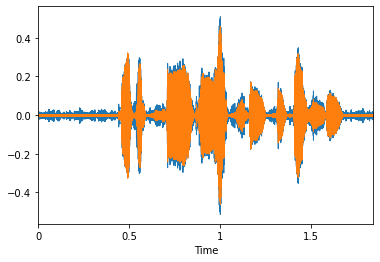

In [53]:
librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[23]).numpy(),-1))
librosa.display.waveplot(np.squeeze(predict(noisy_sounds[23])))